# SVC

In [44]:
#import packages

#pandas and numpy
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


In [45]:
from sklearn.svm import LinearSVC

In [46]:
#read the dataset
df_train = pd.read_csv("Data/train_data_with_editcounts_isperson.csv")

In [47]:
df_train.head()

,EditType,EditID,comment,user,user_edit_count,user_distinct_pages,user_warns,user_reg_time,prev_user,common,...,num_recent_edits,num_recent_reversions,current_minor,current_timestamp,added_lines,previous_timestamp,deleted_lines,isvandalism,num_edits_5d_before,is_person
0,change,329595189,NaN,Nryan30,66,13,0,1259891940,219.78.124.42,NaN,...,0,0,False,1259894598,",==Leadership Through Emotion==,""Leadership is...",1259856305,NaN,False,1,0
1,change,232199357,/* Penis */,89.242.200.212,4,2,2,20080815230001,66.75.235.255,NaN,...,0,0,False,1218841201,It's fucking big.,1218816231,"""Falcon gained media attention after appearing...",True,4,1
2,change,329877752,Reverted edits by [[Special:Contributions/71.2...,Chamal N,18697,0,2,1208605428,71.208.113.72,NaN,...,2,1,True,1260025124,"""Japanese modern drama in the early twentieth ...",1260025104,""".nmbhgsdj;kfhds;akjfhds;fkjhsf;kjdshf;sdkjhfd...",False,3,0
3,change,253129486,NaN,Animaldudeyay1009,3,1,2,1227241317,J.delanoy,NaN,...,0,0,False,1227241840,I LIKE CHEESE. CHEESE IS GOOD. CHOCOLATE MILK ...,1227241120,"""A '''kaleidoscope''' is a tube of [[mirror]]s...",True,2,0
4,change,394520551,Adding Persondata using [[Project:AWB|AWB]] (7...,RjwilmsiBot,1602950,1309238,0,1257977968,LobãoV,NaN,...,0,0,True,1288757547,{{Persondata <!-- Metadata: see [[Wikipedia:Pe...,1285262356,",",False,0,1


In [48]:
#select features and target
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before','is_person','current_minor']
target = 'isvandalism'

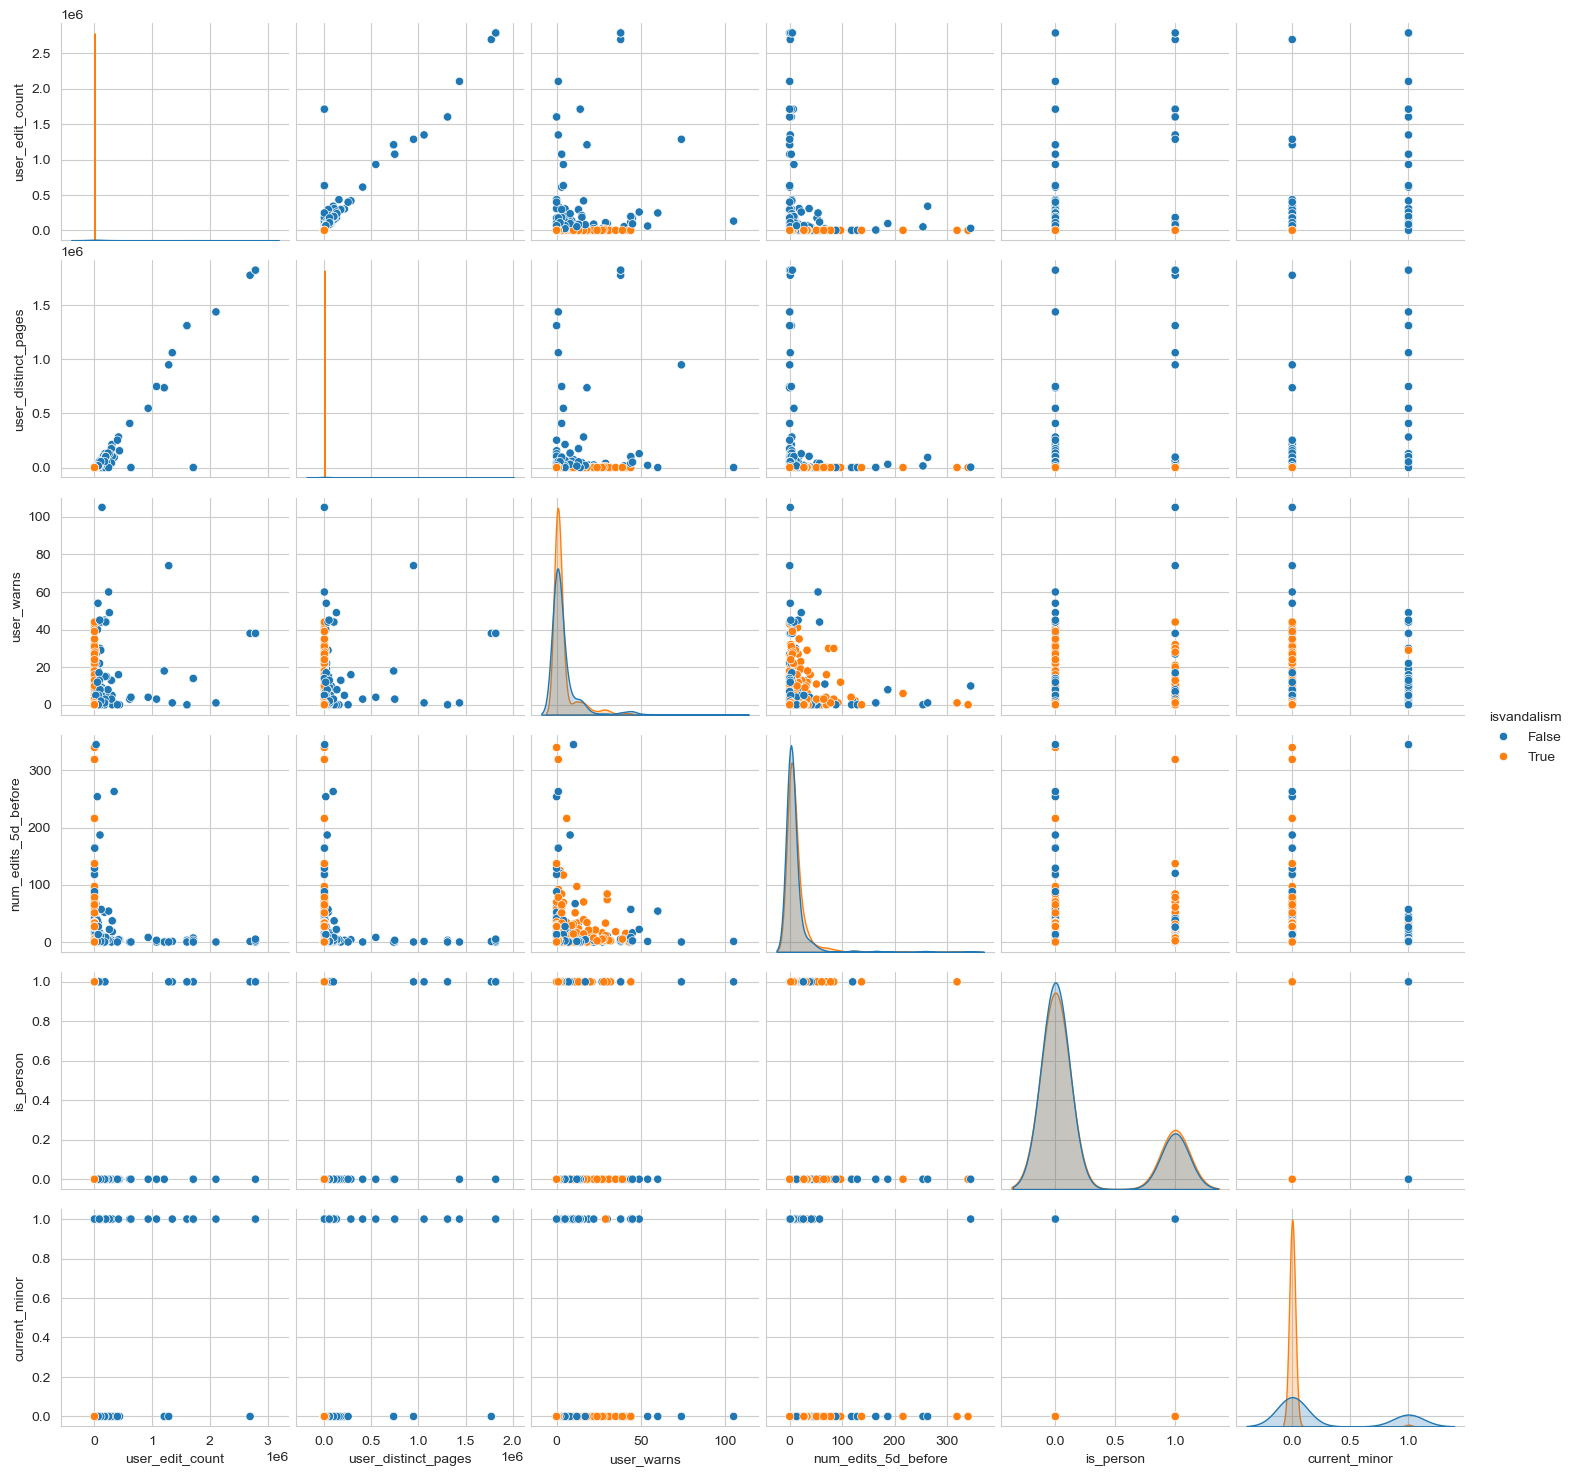

In [49]:
# Combine features and target into one list
columns_to_use = features + [target]

# Sample the data (e.g., 1000 rows or 10% of the data)
df_sampled = df_train[columns_to_use].sample(n=1000, random_state=42)

# Create the pairplot
sns.pairplot(df_sampled, hue=target)

In [71]:
## set the number of CV folds
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=2013, 
                        shuffle=True)


## the values of C you will try
# when testing [.01, .1, 1, 10, 25, 50, 75, 100, 125, 150], got 150 as best
# when testing more, we got 3000 as the best
Cs = [1,10,100,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,10000]

## this will hold the CV accuracies
C_accs1 = np.zeros((n_splits, len(Cs)))

In [ ]:
## the cross-validation
# note: just svc works a little better, but LinearSVC works almost 10x faster
for i,(train_index, test_index) in enumerate(kfold.split(df_train, df_train.isvandalism)):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    for j,C in enumerate(Cs):
        pipe = Pipeline([('scale', StandardScaler()),
                            ('svm', LinearSVC(C=C,max_iter=100000))])
    
        pipe.fit(df_tt[features],
                    df_tt.isvandalism)
    
        pred = pipe.predict(df_ho[features])

        C_accs1[i, j] = accuracy_score(df_ho.isvandalism, pred)

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wp/hnvkck7x0_g862sl3fq8_yzh0000gq/T/ipykernel_28862/2569627199.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log(C)$", fontsize=12)


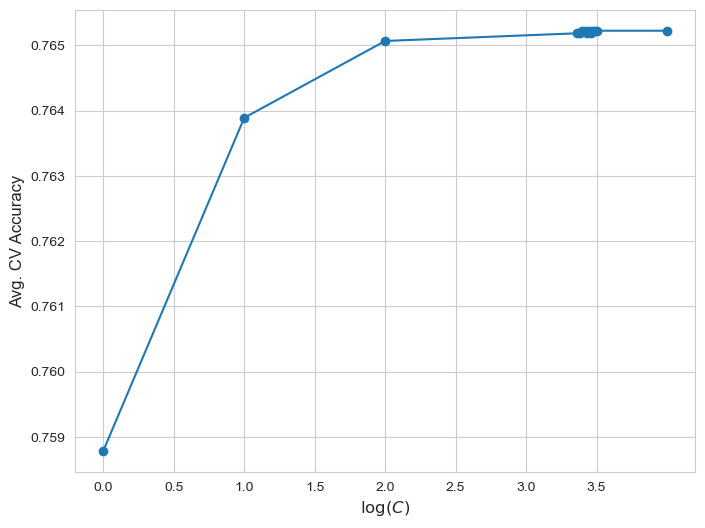

In [73]:
plt.figure(figsize = (8,6))

plt.plot(np.log10(np.array(Cs)), 
         np.mean(C_accs1, axis=0), 
         '-o')

plt.xlabel("$\log(C)$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)
plt.xticks(np.arange(np.log(Cs[0]),np.log10(Cs[-1]),.5),fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [74]:
mean_cv_accuracy = np.mean(C_accs1, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cs[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

The optimal C was 2500 which gave a mean CV accuracy of 0.765
